In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # pour afficher la map de corrélation
import scipy as sc # H0 = non-correlation (assumption that each dataset is normally distributed)
from sklearn.metrics import r2_score

dataframe = pd.read_csv("./data/conso/conso_2018.csv")
dataframe.columns

Index(['mois', 'jour', 'heure', 'consommation', 'prevision_1', 'prevision_0',
       'fioul', 'charbon', 'gaz', 'nucleaire', 'eolien', 'solaire',
       'hydraulique', 'pompage', 'bioenergies', 'echanges_physiques',
       'taux_co2', 'echanges_angleterre', 'echanges_espagne',
       'echanges_italie', 'echanges_suisse', 'echanges_allemagne_belgique',
       'fioul_tac', 'fioul_cogen', 'fioul_autres', 'gaz_tac', 'gaz_cogen',
       'gaz_ccg', 'gaz_autres', 'hydro_ecluses', 'hydro_lacs',
       'hydro_turbines', 'bio_dechets', 'bio_biomasse', 'bio_biogaz'],
      dtype='object')

# from split import retrieve, retrieve_and_split

In [18]:
def retrieve(year):
    """Retrieve data"""
    path_X =  "./data/conso/conso_" + str(year) + ".csv"
    path_Y =  "./data/pertes/pertes_" + str(year) + ".csv"
    X = pd.read_csv(path_X).to_numpy()
    Y = pd.read_csv(path_Y).to_numpy()[:, 3]
    
    return X, Y

def retrieve_and_split(year):
    """Retrieve and split data
    into train/val/test datasets"""
    size_1 = 0.70
    size_2 = 0.85

    path_X = "./data/conso/conso_" + str(year) + ".csv"
    path_Y = "./data/pertes/pertes_" + str(year) + ".csv"
    X = pd.read_csv(path_X).to_numpy()
    Y = pd.read_csv(path_Y).to_numpy()[:, 3]

    n = len(X)
    n_1 = int(size_1*n)
    n_2 = int(size_2*n)

    r = np.random.permutation(n)

    X_train = X[r[0:n_1], :]
    Y_train = Y[r[0:n_1]]
    X_val = X[r[n_1:n_2], :]
    Y_val = Y[r[n_1:n_2]]
    X_test = X[r[n_2:], :]
    Y_test = Y[r[n_2:]]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test

# from utils import add_ones

In [20]:
def add_ones(X):
    """ Adds a column of ones in the beginning of X"""
    ones = np.ones(X.shape[0])
    ones.shape = (X.shape[0], 1)
    return np.concatenate((ones, X), axis=1)

# Code

In [62]:
X, Y = retrieve(2018)
X = (X - X.mean(0)) / (X.std(0)+1e-11)

### Test de corrélation (Pearson)

Text(0.5, 1, 'Absolute Pearson correlation between features')

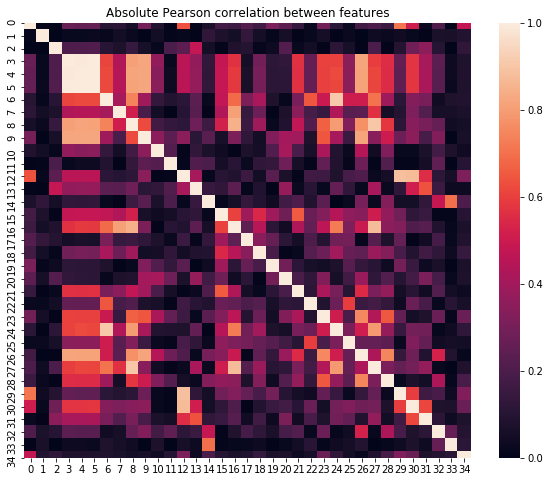

In [23]:
n, p = X.shape

inner_corr = np.zeros((p, p))
target_corr = np.zeros(p)
for i in range(p):
    target_corr[i] = sc.stats.pearsonr(X[:, i], Y)[0]
    for j in range(p):
        inner_corr[i, j] = sc.stats.pearsonr(X[:, i], X[:, j])[0]

# afficher la map de corrélation entre features

plt.figure(figsize=(10,8))
sns.heatmap(abs(inner_corr), annot=False)
plt.title("Absolute Pearson correlation between features")

Les features 3, 4 et 5 c'est des doublons : elles sont ultra corrélées entre elles et elles n'apportent aucune infos en plus (les 3 ont les mêmes corrélations avec les autres). 

In [24]:
# trouver les variables répétitives (celles de grande corrélation) et supprimer les doublons

seuil = 0.85 # 0.5 c'est déjà restrictif
high_corr = inner_corr > seuil
for i in range(p):
    high_corr[i, i] = False

possede_doublons = []
for i in range(p):
    if np.sum(high_corr[i]) > 0 :
        possede_doublons.append(i)

# à la main
        
groupes_doublons = []
for i in possede_doublons :
    group = [i]
    for j in range(p) :
        if high_corr[i, j] :
            group.append(j)
    not_sorted_group = group[:]
    group.sort()
    if group not in groupes_doublons:
        groupes_doublons.append(not_sorted_group)

doublons = (4, 5, 12, 24, 16, 27)
no_doublon = np.delete(np.arange(p), doublons)

# automatisé

corr = np.copy(inner_corr)
doublons = []
removed = np.zeros(p)
for i in possede_doublons :
    for j in possede_doublons :
        if high_corr[i, j] :
            index = max(i, j)
            if removed[index] :
                continue
            else :
                doublons.append(index)
                np.delete(corr, index, axis=0)
                np.delete(corr, index, axis=1)
                removed[index] = 1
doublons = tuple(doublons)
no_doublon = np.delete(np.arange(p), doublons)

print("doublons à supprimer pour un seuil de", seuil, ":", doublons)

doublons à supprimer pour un seuil de 0.85 : (4, 5, 24, 16, 27, 29, 30)


Donc (les groupes de corréation sont très claires) :
- 3, 4, 5 sont des doublons (très corrélés et toujours présents dans les mêmes groupes)
- 12, 29, 30 sont des doublons (2 à 2)
- 6, 24 sont des doublons
- 8, 16, 27 sont des doublons

On décide de supprimer : 4, 5, 12, 24, 16, 27.

### Variable selection with Pearson

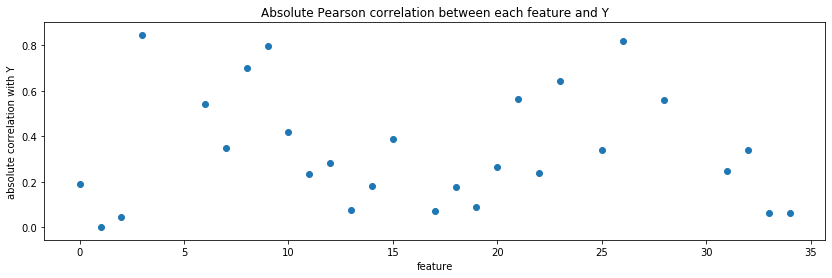

In [25]:
# afficher la map de corrélation entre chaque feature et Y

plt.figure(figsize=(14,4))
plt.scatter(no_doublon, np.delete(abs(target_corr), doublons))
plt.xlabel("feature")
plt.ylabel("absolute correlation with Y")
plt.title("Absolute Pearson correlation between each feature and Y")
plt.show()

In [26]:
# remove the very little correlated feature to Y

seuil = 0.05
low_corr = []
for i in range(p):
    if target_corr[i] < seuil :
        low_corr.append(i)
print(low_corr)

[0, 1, 2, 11, 19, 20, 33, 34]


### Variable selection with PCA

In [27]:
K = np.transpose(X).dot(X)/n
pca_eig_values, pca_eig_vectors = np.linalg.eigh(K)[:2] # the eigen vectors are ordered by ascendant eigen value

def pca(X, l): # l = number of principal components
    E = pca_eig_vectors[:, -l:]
    norm_proj = np.linalg.norm(E, axis=1)
    principal_corr = np.zeros((l, p))
    for i in range(l):
        for j in range(p):
            principal_corr[i, j] = np.sqrt(pca_eig_values[-i-1]) * abs(E[j, -i-1] / K[j, j])
    return norm_proj, np.sum(principal_corr, axis=0)

proj_20, corr_20 = pca(X, 20)
proj_15, corr_15 = pca(X, 15)
proj_10, corr_10 = pca(X, 10)

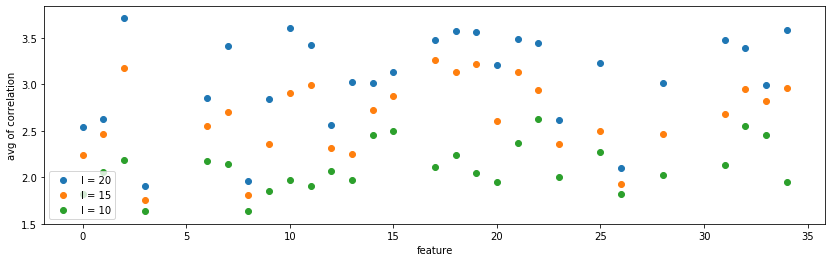

In [28]:
plt.figure(figsize=(14,4))
plt.scatter(no_doublon, np.delete(corr_20, doublons), label="l = 20")
plt.scatter(no_doublon, np.delete(corr_15, doublons), label="l = 15")
plt.scatter(no_doublon, np.delete(corr_10, doublons), label="l = 10")
plt.xlabel("feature")
plt.ylabel("avg of correlation")
plt.legend(loc=3)
plt.show()

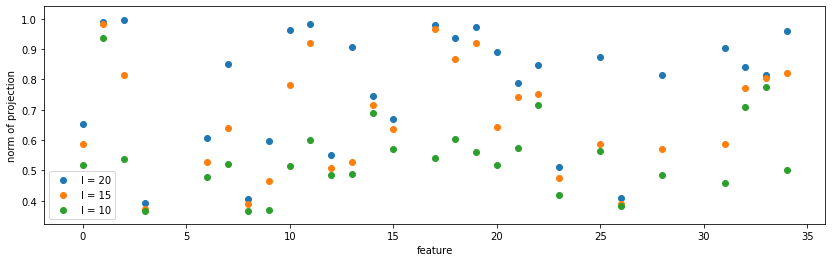

In [29]:
plt.figure(figsize=(14,4))
plt.scatter(no_doublon, np.delete(proj_20, doublons), label="l = 20")
plt.scatter(no_doublon, np.delete(proj_15, doublons), label="l = 15")
plt.scatter(no_doublon, np.delete(proj_10, doublons), label="l = 10")
plt.xlabel("feature")
plt.ylabel("norm of projection")
plt.legend(loc=3)
plt.show()

### Univariate feature selection

In [72]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = retrieve_and_split(2016)
X_train = (X_train - X_train.mean(0)) / np.linalg.norm(X_train)
X_val = (X_val - X_val.mean(0)) / np.linalg.norm(X_val)
X_test = (X_test - X_test.mean(0)) / np.linalg.norm(X_test)

### kNN

feature: 1/35
feature: 2/35
feature: 3/35
feature: 4/35
feature: 5/35
feature: 6/35
feature: 7/35
feature: 8/35
feature: 9/35
feature: 10/35
feature: 11/35
feature: 12/35
feature: 13/35
feature: 14/35
feature: 15/35
feature: 16/35
feature: 17/35
feature: 18/35
feature: 19/35
feature: 20/35
feature: 21/35
feature: 22/35
feature: 23/35
feature: 24/35
feature: 25/35
feature: 26/35
feature: 27/35
feature: 28/35
feature: 29/35
feature: 30/35
feature: 31/35
feature: 32/35
feature: 33/35
feature: 34/35
feature: 35/35
feature: 1/35
feature: 2/35
feature: 3/35
feature: 4/35
feature: 5/35
feature: 6/35
feature: 7/35
feature: 8/35
feature: 9/35
feature: 10/35
feature: 11/35
feature: 12/35
feature: 13/35
feature: 14/35
feature: 15/35
feature: 16/35
feature: 17/35
feature: 18/35
feature: 19/35
feature: 20/35
feature: 21/35
feature: 22/35
feature: 23/35
feature: 24/35
feature: 25/35
feature: 26/35
feature: 27/35
feature: 28/35
feature: 29/35
feature: 30/35
feature: 31/35
feature: 32/35
feature: 33/3

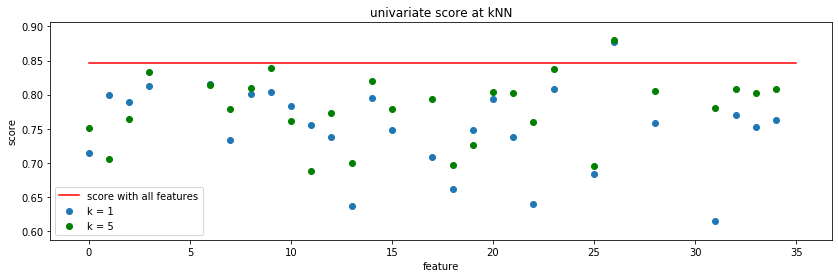

In [154]:
def knn_regression(X_train, Y_train, x, k):
    distances = np.linalg.norm(X_train - x, axis=1)
    neighbors = np.argpartition(distances, k)[:k]
    labels_neighbors = Y_train[neighbors]
    return labels_neighbors.mean()

def knn_error(X_train, Y_train, X_val, Y_val, k):
    error, rate = np.zeros(len(X_val)), np.zeros(len(X_val))
    for i in range(len(X_val)):
        error[i] = abs(knn_regression(X_train, Y_train, X_val[i], k) - Y_val[i]) / Y_val[i]
    return error.mean()

def score_knn(k):
    score = np.zeros(p)
    for i in range(p) :
        score[i] = 1 - knn_error(X_train[:, i].reshape(-1, 1), Y_train, X_val[:, i].reshape(-1, 1), Y_val, k)
    return score

score_full = 1 - knn_error(X_train, Y_train, X_val, Y_val, k)

plt.figure(figsize=(14,4))
plt.scatter(no_doublon, np.delete(score_knn(1), doublons), label="k = 1")
plt.scatter(no_doublon, np.delete(score_knn(5), doublons), c='green', label="k = 5")
plt.plot([0, p], [score_full, score_full], c='red', label='score with all features')
plt.xlabel("feature")
plt.ylabel("score")
plt.title("univariate score at kNN")
plt.legend(loc=3)
plt.show()

Observer les features pour lesquels regarder 5 voisins est moins performant que de regarder 1 voisin.

### SVM

In [155]:
class SAGRegressor(): 
    def __init__(self, lambada=0.001, eta=0.01): 
        self.lambada = lambada 
        self.eta = eta
        self.w = None
        self.b = None
        self.loss_evo_epoch = None
        self.loss_evo_lambda_eta = None
    
    def f(self, X):
        return X.dot(self.w) + self.b

    def l(self, X, Y):
        return (Y - self.f(X))**2
    
    def fit(self, X, Y, epochs=5):
        n, p = X.shape
        # warm start
        if (self.w is None) and (self.b is None) :
            self.w = np.zeros(p)
            self.b = 0
        self.loss_evo_epoch = np.zeros(0)
        indices = np.arange(n)
        gw = np.zeros((n, p)) # vector of most recent loss gradient in w
        gb = np.zeros(n) # vector of most recent loss gradient in b
        dw = np.zeros(p) # sum of gw
        db = 0 # sum of gb
        for ep in range(epochs):
            np.random.shuffle(indices)
            for k in range(n):
                m = min(k+1+n*ep, n)
                i = indices[k]
                dw -= gw[i]
                db -= gb[i]
                # update the gradients
                gb[i] = - 2 * (Y[i] - self.f(np.reshape(X[i], [1, -1])))
                gw[i] = X[i] * gb[i]
                # uptade the sum of gradients
                dw += gw[i]
                db += gb[i]
                # update w and b                
                self.w = (1 - self.eta*self.lambada)*self.w - (self.eta / m) * dw
                self.b -= (self.eta / m) * db
            self.loss_evo_epoch = np.append(self.loss_evo_epoch, self.l(X, Y).mean())
        return
        
    def predict(self, X):
        return self.f(X)

In [156]:
# avec toutes les features

SAG = SAGRegressor(lambada=0.01, eta=0.03)
SAG.fit(X_train, Y_train, epochs=50)
error = abs(SAG.predict(X_val) - Y_val) / Y_val
score_full = 1 - error.mean()

In [157]:
# univariate

score_svm = np.zeros(p)
for i in range(p) :
    print("feature" + i, flush=True)
    SAG = SAGRegressor(lambada=0.01, eta=0.03)
    SAG.fit(X_train[:100, i].reshape(-1, 1), Y_train, epochs=50)
    error = abs(SAG.predict(X_val[:100, i].reshape(-1, 1)) - Y_val) / Y_val
    score_svm[i] = 1 - error.mean()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


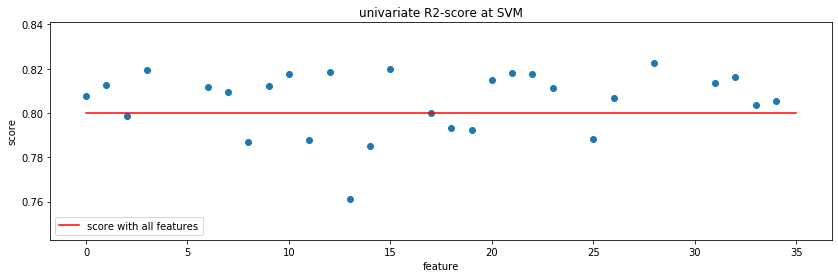

In [158]:
plt.figure(figsize=(14,4))
plt.scatter(no_doublon, np.delete(score_svm, doublons))
plt.plot([0, p], [score_full, score_full], c='red', label='score with all features')
plt.xlabel("feature")
plt.ylabel("score")
plt.title("univariate R2-score at SVM")
plt.legend(loc=3)
plt.show()

# from ksvm import poly_kernel, gauss_kernel, SDCARegressor

In [161]:
def poly_kernel(x1, x2, param):
    return np.dot(x1, x2)**param

def gauss_kernel(x1, x2, param):
    return np.exp(- param * np.linalg.norm(x1 - x2)**2)

class SDCARegressor():
    def __init__(self, kernel, param, C = 10):
        self.kernel = kernel
        self.param = param
        self.C = C
        self.X = None
        self.Y = None
        self.alpha = None
        
    def fit(self, X, Y, epochs = 100, Visual = False):
        
        def dual_Loss(alpha, X, Y, k):
            n = X.shape[0]
            return sum([alpha[i]*Y[i] - (alpha[i]**2)/4 for i in range(n)]) - (1/(2*self.C))*sum([alpha[i]*alpha[j]*k(X[i], X[j], self.param) for i in range(n) for j in range(n)])
        
        X_ones = add_ones(X)
        n, p = X_ones.shape
        self.alpha = np.zeros(n)
        self.Y = Y
        self.X = X_ones
        loss_values = []
        for k in range(epochs):
            perm = np.random.permutation(n)
            for i in perm:
                delta_i = (self.Y[i] - sum([self.alpha[j]*self.kernel(self.X[i], self.X[j], self.param) for j in range(n)]) - (1/2)*self.alpha[i])/((1/2) + self.kernel(self.X[i], self.X[i], self.param)/self.C)
                self.alpha[i] = self.alpha[i] + delta_i
                print('training, iteration: '+str(k+1)+'/'+str(epochs)+'\r', sep=' ', end='', flush=True)
            if Visual:
                loss_values.append(dual_Loss(self.alpha, X_ones, Y, self.kernel))
            
        if Visual:
            it = range(len(loss_values))
            plt.figure()
            plt.plot(it, loss_values, 'r')
            plt.title("Loss over epochs")
            plt.show()
            
    def predict(self, X):
        X_ones = add_ones(X)
        n = self.X.shape[0]
        m = X_ones.shape[0]
        Y_pred = np.array([sum([(1/self.C)*self.alpha[i]*self.kernel(self.X[i], X_ones[j], self.param) for i in range(n)]) for j in range(m)])
        return Y_pred
    
    def weights(self):
        return self.alpha

In [165]:
# avec toutes les features

sdca = SDCARegressor(gauss_kernel, param = 0.001, C = 1)
sdca.fit(X_train[:100], Y_train[:100], epochs = 10, Visual = False)
error = abs(sdca.predict(X_val) - Y_val) / Y_val
score_full = 1 - error.mean()

In [169]:
# univariate

score_ksvm = np.zeros(p)
for i in range(p) :
    print('feature: '+str(i+1)+'/'+str(p)+'\r')
    sdca = SDCARegressor(gauss_kernel, param = 0.001, C = 1)
    sdca.fit(X_train[:100, i].reshape(-1, 1), Y_train[:100], epochs=10)
    error = abs(sdca.predict(X_val[:, i].reshape(-1, 1)) - Y_val) / Y_val
    score_ksvm[i] = 1 - error.mean()

feature: 1/35
feature: 2/35ration: 10/10
feature: 3/35ration: 10/10
feature: 4/35ration: 10/10
feature: 5/35ration: 10/10
feature: 6/35ration: 10/10
feature: 7/35ration: 10/10
feature: 8/35ration: 10/10
feature: 9/35ration: 10/10
feature: 10/35ation: 10/10
feature: 11/35ation: 10/10
feature: 12/35ation: 10/10
feature: 13/35ation: 10/10
feature: 14/35ation: 10/10
feature: 15/35ation: 10/10
feature: 16/35ation: 10/10
feature: 17/35ation: 10/10
feature: 18/35ation: 10/10
feature: 19/35ation: 10/10
feature: 20/35ation: 10/10
feature: 21/35ation: 10/10
feature: 22/35ation: 10/10
feature: 23/35ation: 10/10
feature: 24/35ation: 10/10
feature: 25/35ation: 10/10
feature: 26/35ation: 10/10
feature: 27/35ation: 10/10
feature: 28/35ation: 10/10
feature: 29/35ation: 10/10
feature: 30/35ation: 10/10
feature: 31/35ation: 10/10
feature: 32/35ation: 10/10
feature: 33/35ation: 10/10
feature: 34/35ation: 10/10
feature: 35/35ation: 10/10


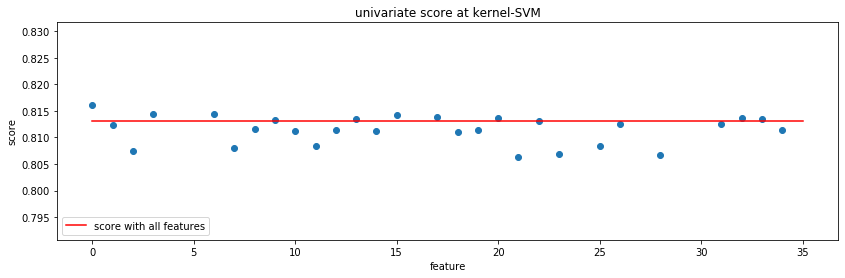

In [170]:
plt.figure(figsize=(14,4))
plt.scatter(no_doublon, np.delete(score_ksvm, doublons))
plt.plot([0, p], [score_full, score_full], c='red', label='score with all features')
plt.xlabel("feature")
plt.ylabel("score")
plt.title("univariate score at kernel-SVM")
plt.legend(loc=3)
plt.show()